In [12]:
'''
Trains a spatio-temporal NN model on deep squat movement from the KIMORE dataset acquired with Kinect v2 sensor
For a detailed explanation of the data and the model please see the article
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
now = datetime.datetime.now
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from math import sqrt

# length of data sequences
seq_len = 104
# dimension of data sequences
n_dim = 75
batch_size = 2

In [13]:
import Data_Load
X_train, y_train = Data_Load.load_data()

# The temporal pyramid requires that the length of the data sequences is divisible by 8.
# The original length was 100 time steps, so we will repeat the first and last 2 data vectors to obtain sequences with 104 time steps
X_train = np.concatenate((X_train[:,:2,:], X_train, X_train[:,-3:-1,:]), axis = 1)

print('Training sequences dimension', X_train.shape)
print('Testing labels dimension', y_train.shape)

Training sequences dimension (204, 104, 88)
Testing labels dimension (204,)


In [14]:
# Split the data into training and validation sets
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3)
print('Training data', train_x.shape)
print('Validation data', valid_x.shape)

Training data (142, 104, 88)
Validation data (62, 104, 88)


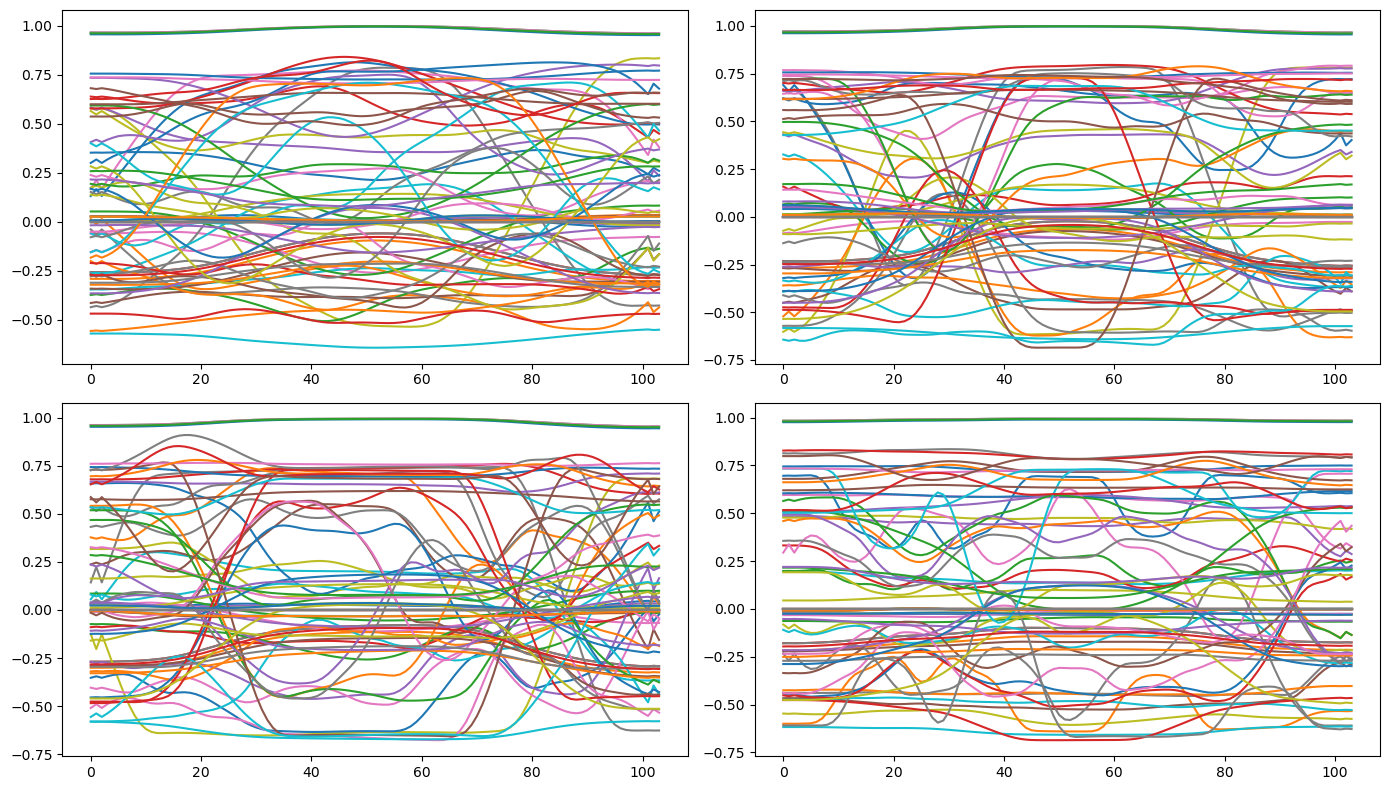

In [15]:
# Plot the first and last sequences in the training and validation data
plt.figure(figsize = (14,8))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.tight_layout()
plt.show()

In [16]:
# Reduce the data length by a factor of 2, 4, and 8 
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
valid_x_2 = np.zeros(train_x_2.shape)
train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
valid_x_4 = np.zeros(train_x_4.shape)
train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
valid_x_8 = np.zeros(train_x_8.shape)
train_x_2 = train_x[:,::2,:]
valid_x_2 = valid_x[:,::2,:]
train_x_4 = train_x[:,::4,:]
valid_x_4 = valid_x[:,::4,:]
train_x_8 = train_x[:,::8,:]
valid_x_8 = valid_x[:,::8,:]  

In [17]:
# Code to re-order the 88 dimensional skeleton data from Kinect into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0],x.shape[1],16))
    X_left_arm = np.zeros((x.shape[0],x.shape[1],16))
    X_right_arm = np.zeros((x.shape[0],x.shape[1],16))
    X_left_leg = np.zeros((x.shape[0],x.shape[1],16))
    X_right_leg = np.zeros((x.shape[0],x.shape[1],16))
    X_trunk =  x[:,:,0:16]
    X_left_arm = x[:,:,16:32]
    X_right_arm = x[:,:,32:48]
    X_left_leg = x[:,:,48:64]
    X_right_leg = x[:,:,64:80]
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented

In [18]:
# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
trainx_2 =  reorder_data(train_x_2)
validx_2 =  reorder_data(valid_x_2)
trainx_4 =  reorder_data(train_x_4)
validx_4 =  reorder_data(valid_x_4)
trainx_8 =  reorder_data(train_x_8)
validx_8 =  reorder_data(valid_x_8)

In [19]:
# Define a multibranch convolutional Inception-like block
def MultiBranchConv1D(input, filters1, kernel_size1, strides1, strides2):
    x1 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides1, padding='same', activation='relu')(input)
    x1 = Dropout(0.25)(x1)
    x2 = Conv1D(filters=filters1, kernel_size=kernel_size1+6, strides=strides1, padding='same', activation='relu')(input)
    x2 = Dropout(0.25)(x2)
    x3 = Conv1D(filters=filters1, kernel_size=kernel_size1+12, strides=strides1, padding='same', activation='relu')(input)
    x3 = Dropout(0.25)(x3)
    y1 = concatenate([x1, x2, x3], axis=-1)

    x4 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=strides2, padding='same', activation='relu')(y1)
    x4 = Dropout(0.25)(x4)
    x5 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides2, padding='same', activation='relu')(y1)
    x5 = Dropout(0.25)(x5)
    x6 = Conv1D(filters=filters1, kernel_size=kernel_size1+4, strides=strides2, padding='same', activation='relu')(y1)
    x6 = Dropout(0.25)(x6)
    x = concatenate([x4, x5, x6], axis=-1)                                                                                                                                   
    return x

In [20]:
# Define a temporal pyramid network
def TempPyramid(input_f, input_2, input_4, input_8, seq_len, n_dims):
    
    #### Full scale sequences
    conv1 = MultiBranchConv1D(input_f, 64, 3, 2, 2)

    #### Half scale sequences
    conv2 = MultiBranchConv1D(input_2, 64, 3, 2, 1)

    #### Quarter scale sequences
    conv3 = MultiBranchConv1D(input_4, 64, 3, 1, 1)

    #### Eighth scale sequences
    conv4 = MultiBranchConv1D(input_8, 64, 3, 1, 1)
    upsample1 = UpSampling1D(size = 2)(conv4)

    #### Recurrent layers
    x = concatenate([conv1, conv2, conv3, upsample1], axis=-1)
    return x    

In [23]:
n_dim = 80 # dimension after reordering the data into body parts
n_dim1 = 16 # dimension of indiviudal body parts

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (seq_len,n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:, :, 0:16])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 16:32])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 32:48])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 48:64])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 64:80])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(seq_len/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:16])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 16:32])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 32:48])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 48:64])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 64:80])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(seq_len/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:16])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 16:32])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 32:48])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 48:64])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 64:80])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(seq_len/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:16])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 16:32])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 32:48])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 48:64])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 64:80])(seq_input_8)

concat_trunk = TempPyramid(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8, seq_len, n_dim1)
concat_left_arm = TempPyramid(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8, seq_len, n_dim1)
concat_right_arm = TempPyramid(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8, seq_len, n_dim1)
concat_left_leg = TempPyramid(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8, seq_len, n_dim1)
concat_right_leg = TempPyramid(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8, seq_len, n_dim1)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

rec = LSTM(80, return_sequences=True)(concat)
rec1 = LSTM(40, return_sequences=True)(rec)
rec1 = LSTM(40, return_sequences=True)(rec1)
rec2 = LSTM(80)(rec1)

out = Dense(1, activation = 'sigmoid')(rec2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.0001)) 


In [24]:
t = now()
    
early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=10, epochs=500, verbose=0, 
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Training time: 0:04:19.560239


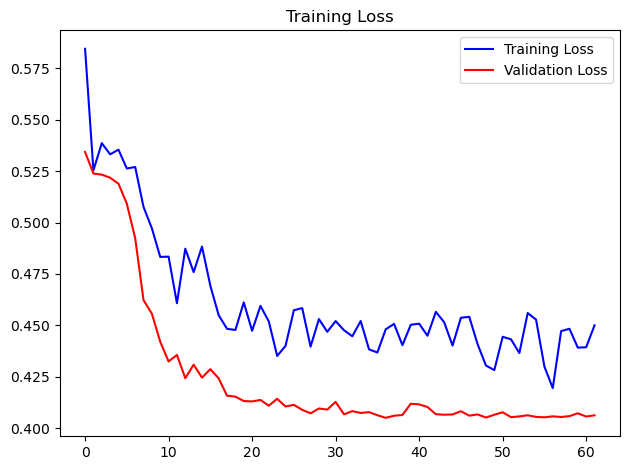

Training loss 0.4194459319114685
Validation loss 0.40497922897338867


In [25]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))   

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


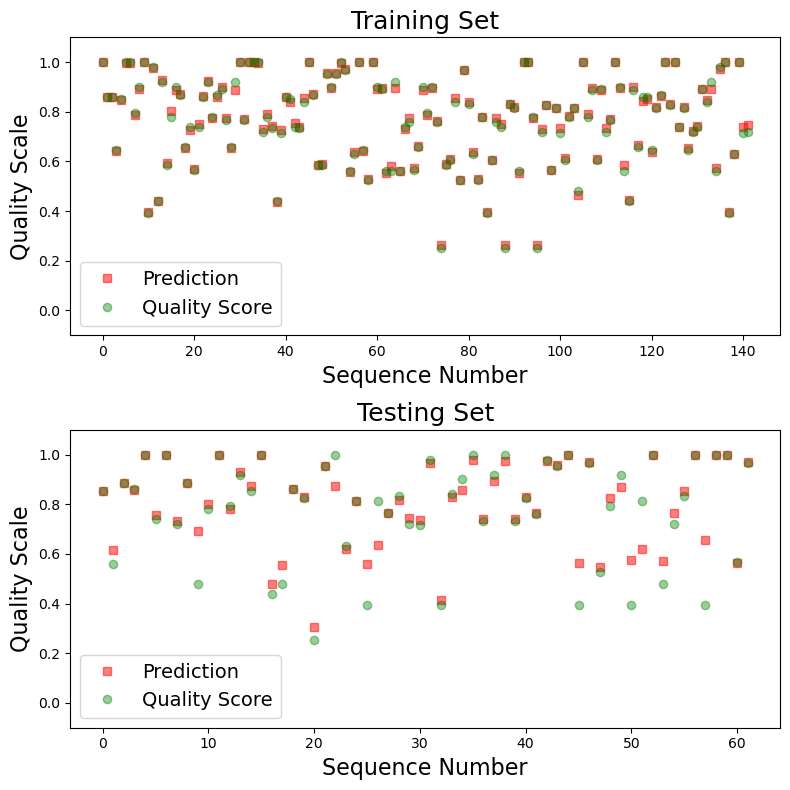

In [28]:
# Plot the prediction of the model for the training and validation sets
pred_train = model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = model.predict([validx, validx_2, validx_4, validx_8])

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
plt.show()

In [29]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-valid_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.0382949104135267
RMS deviation: 0.07245116046580535
